# Inference notenook for [CLIP prefix captioning](https://github.com/rmokady/CLIP_prefix_caption/)

Disclaimer: the authors do not own any rights for the code or data.

In [1]:
#@title Install
!pip install transformers
! pip install git+https://github.com/openai/CLIP.git


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-xx2h0ha8
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-xx2h0ha8
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done


In [3]:
!pip install google-colab

Defaulting to user installation because normal site-packages is not writeable
  Using cached google-colab-1.0.0.tar.gz (72 kB)
  Preparing metadata (setup.py) ... done
  Using cached google_auth-1.4.2-py2.py3-none-any.whl (64 kB)
  Using cached ipykernel-4.6.1-py3-none-any.whl (104 kB)
  Using cached ipython-5.5.0-py3-none-any.whl (758 kB)
  Using cached notebook-5.2.2-py2.py3-none-any.whl (8.0 MB)
  Using cached six-1.12.0-py2.py3-none-any.whl (10 kB)
  Using cached pandas-0.24.2.tar.gz (11.8 MB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [13 lines of output]
      /mlainas/bubble3jh/anaconda3/envs/farcon/lib/python3.8/site-packages/setuptools/__init__.py:84: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
      !!
      
              ********************************************************************************
              Requirem

In [1]:
#@title Drive Downloader

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
# from google.colab import auth
from oauth2client.client import GoogleCredentials

download_with_pydrive = True #@param {type:"boolean"}

class Downloader(object):
    def __init__(self, use_pydrive):
        self.use_pydrive = use_pydrive

        if self.use_pydrive:
            self.authenticate()

    def authenticate(self):
        auth.authenticate_user()
        gauth = GoogleAuth()
        gauth.credentials = GoogleCredentials.get_application_default()
        self.drive = GoogleDrive(gauth)

    def download_file(self, file_id, file_dst):
        if self.use_pydrive:
            downloaded = self.drive.CreateFile({'id':file_id})
            downloaded.FetchMetadata(fetch_all=True)
            downloaded.GetContentFile(file_dst)
        else:
            !gdown --id $file_id -O $file_dst

downloader = Downloader(download_with_pydrive)

In [18]:
!python -m pip install protobuf==3.20.0

Defaulting to user installation because normal site-packages is not writeable


In [20]:
!which python

/mlainas/bubble3jh/anaconda3/envs/farcon/bin/python


In [58]:
#@title Imports

import clip
import os
from torch import nn
import numpy as np
import torch
import torch.nn.functional as nnf
import sys
from typing import Tuple, List, Union, Optional
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import skimage.io as io
import PIL.Image
from IPython.display import Image
from enum import Enum


N = type(None)
V = np.array
ARRAY = np.ndarray
ARRAYS = Union[Tuple[ARRAY, ...], List[ARRAY]]
VS = Union[Tuple[V, ...], List[V]]
VN = Union[V, N]
VNS = Union[VS, N]
T = torch.Tensor
TS = Union[Tuple[T, ...], List[T]]
TN = Optional[T]
TNS = Union[Tuple[TN, ...], List[TN]]
TSN = Optional[TS]
TA = Union[T, ARRAY]


D = torch.device
CPU = torch.device('cpu')


def get_device(device_id: int) -> D:
    if not torch.cuda.is_available():
        return CPU
    device_id = min(torch.cuda.device_count() - 1, device_id)
    return torch.device(f'cuda:{device_id}')


CUDA = get_device

current_directory = os.getcwd()
save_path = os.path.join(os.path.dirname(current_directory), "pretrained_models")
os.makedirs(save_path, exist_ok=True)

#@title Choose pretrained model - COCO or Coneptual captions


pretrained_model = 'Conceptual captions'  # @param ['COCO', 'Conceptual captions']

if pretrained_model == 'Conceptual captions':
  model_path = os.path.join(save_path, 'conceptual_weights.pt')
else:
  model_path = os.path.join(save_path, 'coco_weights.pt')



pip protobuf 4.24.1

In [59]:
#@title Model

class MLP(nn.Module):

    def forward(self, x: T) -> T:
        return self.model(x)

    def __init__(self, sizes: Tuple[int, ...], bias=True, act=nn.Tanh):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(sizes) -1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=bias))
            if i < len(sizes) - 2:
                layers.append(act())
        self.model = nn.Sequential(*layers)


class ClipCaptionModel(nn.Module):

    #@functools.lru_cache #FIXME
    def get_dummy_token(self, batch_size: int, device: D) -> T:
        return torch.zeros(batch_size, self.prefix_length, dtype=torch.int64, device=device)

    def forward(self, tokens: T, prefix: T, mask: Optional[T] = None, labels: Optional[T] = None):
        embedding_text = self.gpt.transformer.wte(tokens)
        prefix_projections = self.clip_project(prefix).view(-1, self.prefix_length, self.gpt_embedding_size)
        #print(embedding_text.size()) #torch.Size([5, 67, 768])
        #print(prefix_projections.size()) #torch.Size([5, 1, 768])
        embedding_cat = torch.cat((prefix_projections, embedding_text), dim=1)
        if labels is not None:
            dummy_token = self.get_dummy_token(tokens.shape[0], tokens.device)
            labels = torch.cat((dummy_token, tokens), dim=1)
        out = self.gpt(inputs_embeds=embedding_cat, labels=labels, attention_mask=mask)
        return out

    def __init__(self, prefix_length: int, prefix_size: int = 512):
        super(ClipCaptionModel, self).__init__()
        self.prefix_length = prefix_length
        self.gpt = GPT2LMHeadModel.from_pretrained('gpt2')
        self.gpt_embedding_size = self.gpt.transformer.wte.weight.shape[1]
        if prefix_length > 10:  # not enough memory
            self.clip_project = nn.Linear(prefix_size, self.gpt_embedding_size * prefix_length)
        else:
            self.clip_project = MLP((prefix_size, (self.gpt_embedding_size * prefix_length) // 2, self.gpt_embedding_size * prefix_length))


class ClipCaptionPrefix(ClipCaptionModel):

    def parameters(self, recurse: bool = True):
        return self.clip_project.parameters()

    def train(self, mode: bool = True):
        super(ClipCaptionPrefix, self).train(mode)
        self.gpt.eval()
        return self

In [60]:
#@title Caption prediction

def generate_beam(model, tokenizer, beam_size: int = 5, prompt=None, embed=None,
                  entry_length=67, temperature=1., stop_token: str = '.'):

    model.eval()
    stop_token_index = tokenizer.encode(stop_token)[0]
    tokens = None
    scores = None
    device = next(model.parameters()).device
    seq_lengths = torch.ones(beam_size, device=device)
    is_stopped = torch.zeros(beam_size, device=device, dtype=torch.bool)
    with torch.no_grad():
        if embed is not None:
            generated = embed
        else:
            if tokens is None:
                tokens = torch.tensor(tokenizer.encode(prompt))
                tokens = tokens.unsqueeze(0).to(device)
                generated = model.gpt.transformer.wte(tokens)
        for i in range(entry_length):
            outputs = model.gpt(inputs_embeds=generated)
            logits = outputs.logits
            logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
            logits = logits.softmax(-1).log()
            if scores is None:
                scores, next_tokens = logits.topk(beam_size, -1)
                generated = generated.expand(beam_size, *generated.shape[1:])
                next_tokens, scores = next_tokens.permute(1, 0), scores.squeeze(0)
                if tokens is None:
                    tokens = next_tokens
                else:
                    tokens = tokens.expand(beam_size, *tokens.shape[1:])
                    tokens = torch.cat((tokens, next_tokens), dim=1)
            else:
                logits[is_stopped] = -float(np.inf)
                logits[is_stopped, 0] = 0
                scores_sum = scores[:, None] + logits
                seq_lengths[~is_stopped] += 1
                scores_sum_average = scores_sum / seq_lengths[:, None]
                scores_sum_average, next_tokens = scores_sum_average.view(-1).topk(beam_size, -1)
                next_tokens_source = next_tokens // scores_sum.shape[1]
                seq_lengths = seq_lengths[next_tokens_source]
                next_tokens = next_tokens % scores_sum.shape[1]
                next_tokens = next_tokens.unsqueeze(1)
                tokens = tokens[next_tokens_source]
                tokens = torch.cat((tokens, next_tokens), dim=1)
                generated = generated[next_tokens_source]
                scores = scores_sum_average * seq_lengths
                is_stopped = is_stopped[next_tokens_source]
            next_token_embed = model.gpt.transformer.wte(next_tokens.squeeze()).view(generated.shape[0], 1, -1)
            generated = torch.cat((generated, next_token_embed), dim=1)
            is_stopped = is_stopped + next_tokens.eq(stop_token_index).squeeze()
            if is_stopped.all():
                break
    scores = scores / seq_lengths
    output_list = tokens.cpu().numpy()
    output_texts = [tokenizer.decode(output[:int(length)]) for output, length in zip(output_list, seq_lengths)]
    order = scores.argsort(descending=True)
    output_texts = [output_texts[i] for i in order]
    return output_texts


def generate2(
        model,
        tokenizer,
        tokens=None,
        prompt=None,
        embed=None,
        entry_count=1,
        entry_length=67,  # maximum number of words
        top_p=0.8,
        temperature=1.,
        stop_token: str = '.',
):
    model.eval()
    generated_num = 0
    generated_list = []
    stop_token_index = tokenizer.encode(stop_token)[0]
    filter_value = -float("Inf")
    device = next(model.parameters()).device

    with torch.no_grad():

        for entry_idx in trange(entry_count):
            if embed is not None:
                generated = embed
            else:
                if tokens is None:
                    tokens = torch.tensor(tokenizer.encode(prompt))
                    tokens = tokens.unsqueeze(0).to(device)

                generated = model.gpt.transformer.wte(tokens)

            for i in range(entry_length):

                outputs = model.gpt(inputs_embeds=generated)
                logits = outputs.logits
                logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(nnf.softmax(sorted_logits, dim=-1), dim=-1)
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[
                                                    ..., :-1
                                                    ].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[:, indices_to_remove] = filter_value
                next_token = torch.argmax(logits, -1).unsqueeze(0)
                next_token_embed = model.gpt.transformer.wte(next_token)
                if tokens is None:
                    tokens = next_token
                else:
                    tokens = torch.cat((tokens, next_token), dim=1)
                generated = torch.cat((generated, next_token_embed), dim=1)
                if stop_token_index == next_token.item():
                    break

            output_list = list(tokens.squeeze().cpu().numpy())
            output_text = tokenizer.decode(output_list)
            generated_list.append(output_text)

    return generated_list[0]

In [49]:
model_path

'/data1/bubble3jh/farcon/Fair-Diffusion/ieat/data/pretrained_models/conceptual_weights.pt'

In [50]:
#@title GPU/CPU


is_gpu = True #@param {type:"boolean"}


In [54]:
#@title CLIP model + GPT2 tokenizer

device = CUDA(0) if is_gpu else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device, jit=False)
# clip_model, preprocess = clip.load("ViT-L/14", device=device, jit=False)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

In [55]:
#@title Load model weights


prefix_length = 10

model = ClipCaptionModel(prefix_length)
print(torch.load(model_path, map_location=CPU).keys())
model.load_state_dict(torch.load(model_path, map_location=CPU), strict=False)

model = model.eval()
device = CUDA(0) if is_gpu else "cpu"
model = model.to(device)


odict_keys(['gpt.transformer.wte.weight', 'gpt.transformer.wpe.weight', 'gpt.transformer.h.0.ln_1.weight', 'gpt.transformer.h.0.ln_1.bias', 'gpt.transformer.h.0.attn.bias', 'gpt.transformer.h.0.attn.masked_bias', 'gpt.transformer.h.0.attn.c_attn.weight', 'gpt.transformer.h.0.attn.c_attn.bias', 'gpt.transformer.h.0.attn.c_proj.weight', 'gpt.transformer.h.0.attn.c_proj.bias', 'gpt.transformer.h.0.ln_2.weight', 'gpt.transformer.h.0.ln_2.bias', 'gpt.transformer.h.0.mlp.c_fc.weight', 'gpt.transformer.h.0.mlp.c_fc.bias', 'gpt.transformer.h.0.mlp.c_proj.weight', 'gpt.transformer.h.0.mlp.c_proj.bias', 'gpt.transformer.h.1.ln_1.weight', 'gpt.transformer.h.1.ln_1.bias', 'gpt.transformer.h.1.attn.bias', 'gpt.transformer.h.1.attn.masked_bias', 'gpt.transformer.h.1.attn.c_attn.weight', 'gpt.transformer.h.1.attn.c_attn.bias', 'gpt.transformer.h.1.attn.c_proj.weight', 'gpt.transformer.h.1.attn.c_proj.bias', 'gpt.transformer.h.1.ln_2.weight', 'gpt.transformer.h.1.ln_2.bias', 'gpt.transformer.h.1.mlp.c

In [56]:
import os
import json
from skimage import io
import PIL
import torch

# 이미지 파일과 캡션을 저장할 딕셔너리
captions_dict = {}
use_beam_search = True

# 시작 디렉토리 경로 설정
start_directory_path = '.'

# 모든 디렉토리와 하위 디렉토리를 순회
for directory_name, _, file_list in os.walk(start_directory_path):
    if directory_name == start_directory_path:  # 최상위 디렉토리는 제외
        continue
    for file_name in file_list:
        # 파일 확장자가 이미지 형식인지 확인 (예: jpg, png)
        if file_name.endswith(('.jpg', '.png')):
            image_path = os.path.join(directory_name, file_name)

            # 이미지 읽기
            image = io.imread(image_path)
            pil_image = PIL.Image.fromarray(image)
            # display(pil_image)

            # 이미지 전처리 및 캡션 생성
            image = preprocess(pil_image).unsqueeze(0).to(device)

            with torch.no_grad():
                # if type(model) is ClipCaptionE2E:
                #     prefix_embed = model.forward_image(image)
                # else:
                prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
                prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)
            if use_beam_search:
                generated_text_prefix = generate_beam(model, tokenizer, embed=prefix_embed)[0]
            else:
                generated_text_prefix = generate2(model, tokenizer, embed=prefix_embed)
            captions_dict[image_path] = generated_text_prefix
            # 캡션 출력
            print(file_name, generated_text_prefix)
output_path = './captions.json'
with open(output_path, 'w') as json_file:
    json.dump(captions_dict, json_file)

print(f"Captions saved to {output_path}")

/tmp/ipykernel_3511927/2332459524.py:42: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  next_tokens_source = next_tokens // scores_sum.shape[1]


yf3.jpg a woman's face is shown in this undated file photo.
ym2.jpg a woman's face is shown in this undated file photo.
ym1.jpg a man's face is shown in this undated file photo.
yf1.jpg a close - up of a woman's face.
yf2.jpg a close - up of a young woman's face.
ym3.jpg a man's face is shown in this undated file photo.
om3.jpg a close - up of a man's face.
of1.jpg a close - up of a man's face.
of2.jpg a man's face is shown in this undated file photo.
of3.jpg a woman's face is shown in this undated file photo.
om2.jpg a close - up of a man's face.
om1.jpg a close - up of a man's face.
gay-people1_google.jpg students hold up a rainbow flag during a protest.
gay-people2_google.jpg a man and a woman kiss during the pride parade and festival.
gay-men3_google.jpg i'm not sure what kind of person this is, but it's pretty cool.
gay2_google.jpg a man holds up a flag during a protest against the government's economic and social reforms.
gay-men1_google.jpg how to wear a bow tie for men.
gay1_go

KeyboardInterrupt: 

In [36]:
import json

# 기존 JSON 파일 경로
input_path = './conception_captions.json'

# 변환된 내용을 저장할 JSON 파일 경로
output_path = './conception_captions_modified.json'

# 기존 JSON 파일 읽기
with open(input_path, 'r') as json_file:
    captions_dict = json.load(json_file)

# 이미지 파일과 캡션을 저장할 리스트
captions_list = []

# 딕셔너리의 키와 값을 순회하며 리스트에 추가
for image_path, caption in captions_dict.items():
    image_caption_pair = {
        "image_path": image_path,
        "caption": caption
    }
    captions_list.append(image_caption_pair)

# 새로운 구조로 JSON 파일 저장
with open(output_path, 'w') as json_file:
    json.dump(captions_list, json_file)

print(f"Captions saved to {output_path}")

Captions saved to ./conception_captions_modified.json


Conceptual captions examples:
https://drive.google.com/file/d/1mzH3b0LQrGEWjEva4hI6HE_fIYRIgtBT/view?usp=sharing

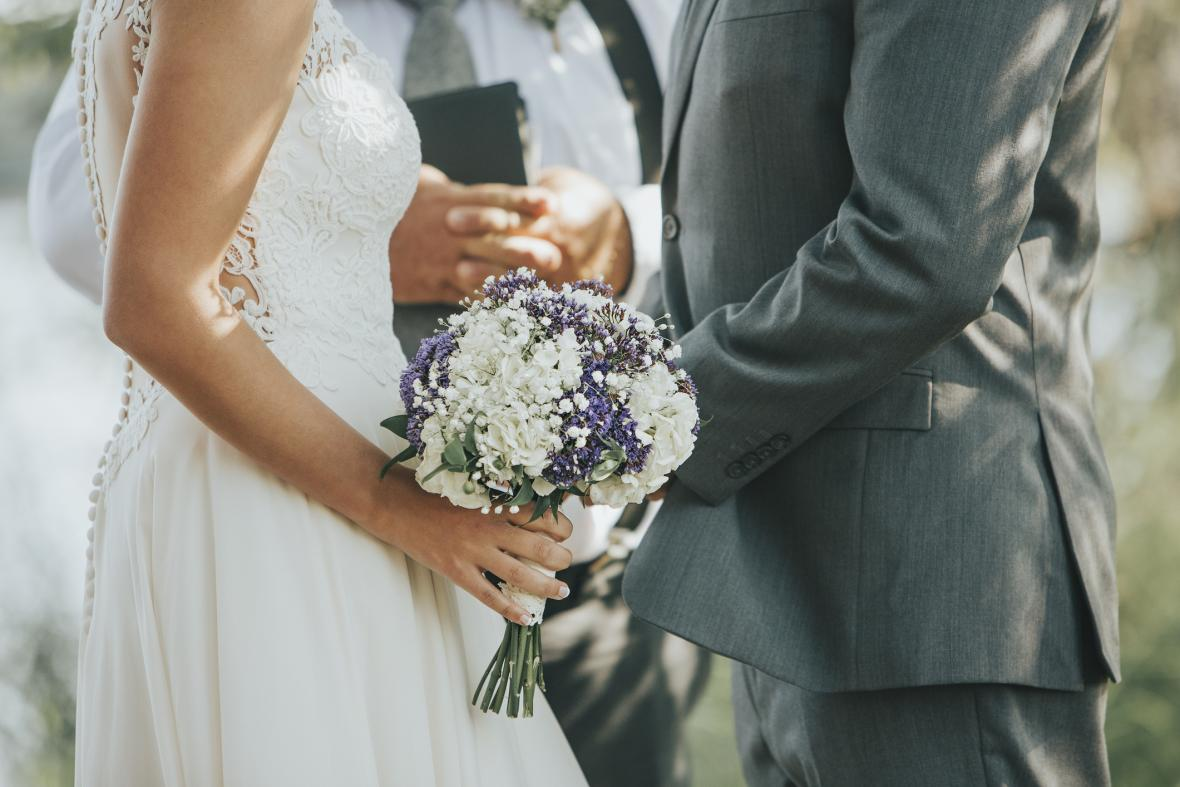



A bride and groom are getting married.


In [25]:
#@title Inference
use_beam_search = True #@param {type:"boolean"}

image = io.imread(UPLOADED_FILE)
pil_image = PIL.Image.fromarray(image)
#pil_img = Image(filename=UPLOADED_FILE)
display(pil_image)

image = preprocess(pil_image).unsqueeze(0).to(device)
with torch.no_grad():
    # if type(model) is ClipCaptionE2E:
    #     prefix_embed = model.forward_image(image)
    # else:
    prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
    prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)
if use_beam_search:
    generated_text_prefix = generate_beam(model, tokenizer, embed=prefix_embed)[0]
else:
    generated_text_prefix = generate2(model, tokenizer, embed=prefix_embed)


print('\n')
print(generated_text_prefix)